# Testing Saturation in Flare Models

In [79]:
import astropy.units as u
import astropy.time
import numpy as np
import matplotlib.pyplot as plt
import sunpy.map
import aiapy
from astropy.visualization import quantity_support,ImageNormalize,LogStretch,AsinhStretch
from astropy.coordinates import SkyCoord
from astropy.wcs.utils import wcs_to_celestial_frame
import ndcube

from mocksipipeline.physics.dem import compute_temperature_response
from mocksipipeline.physics.dem.data_prep import DataPrep
from mocksipipeline.physics.spectral import SpectralModel
from mocksipipeline.detector.response import Channel, SpectrogramChannel, ThinFilmFilter, convolve_with_response

In [2]:
aia_maps = sunpy.map.Map('../pipeline-runs/flare-test/AIA/*.fits')
xrt_maps = sunpy.map.Map('../pipeline-runs/flare-test/XRT/*.fits')

In [3]:
correction_table = aiapy.calibrate.util.get_correction_table() 
pointing_table = aiapy.calibrate.util.get_pointing_table(aia_maps[0].date-6*u.h, aia_maps[0].date+6*u.h)
error_table = aiapy.calibrate.util.get_error_table(
    error_table='/Users/wtbarnes/ssw/sdo/aia/response/aia_V3_error_table.txt'
)

/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 100 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 10 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


In [4]:
temperature_bin_edges = 10**np.arange(5.5, 7.6, 0.1) * u.K

In [5]:
dp = DataPrep(map_list=aia_maps+[xrt_maps,],
              aia_error_table=error_table,
              aia_correction_table=correction_table,
              aia_pointing_table=pointing_table,
              temperature_bin_edges=temperature_bin_edges)

First, compare just the data

/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/astropy/units/quantity.py:626: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/astropy/units/quantity.py:626: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/astropy/units/quantity.py:626: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/astropy/units/quantity.py:626: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/astropy/units

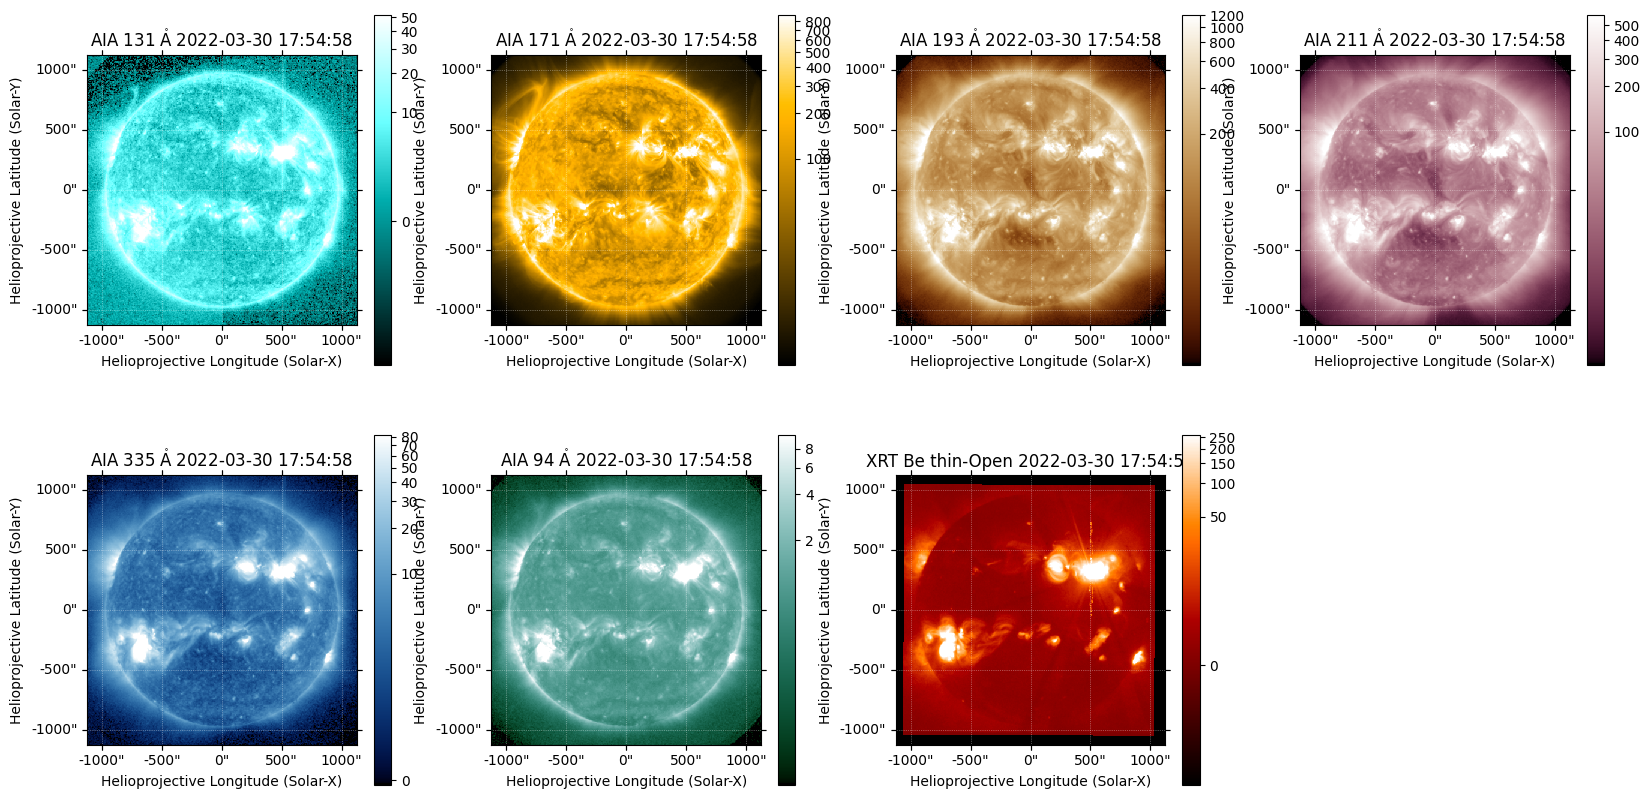

In [6]:
fig = plt.figure(figsize=(20,10))
for i,k in enumerate(dp.collection):
    ax = fig.add_subplot(2,4,i+1,projection=dp.collection[k])
    m = sunpy.map.Map(dp.collection[k].data, dp.collection[k].meta)
    if 'AIA' in m.instrument:
        m.plot_settings["cmap"] = f'sdo{m.plot_settings["cmap"]}'
    im = m.plot(axes=ax, clip_interval=(1,99)*u.percent)
    fig.colorbar(im)

Now, compare the DEM results

In [7]:
dem_cube = dp.run()

/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/demregpy/demmap.py:198: RuntimeWarning: divide by zero encountered in divide
  rmatrixin[:,kk]=rmatrix[:,kk]/ednin[kk]
/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/demregpy/demmap.py:199: RuntimeWarning: divide by zero encountered in divide
  dn=dnin/ednin
/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/demregpy/demmap.py:200: RuntimeWarning: invalid value encountered in divide
  edn=ednin/ednin
  0%|                                                                                                                                   | 0.00/2.02k [00:00<?, ? x10^2 DEM/s]/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/demregpy/demmap.py:198: RuntimeWarning: divide by zero encountered in divide
  rmatrixin[:,kk]=rmatrix[:,kk]/ednin[kk]
/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/demregpy/demmap.py:199: Run

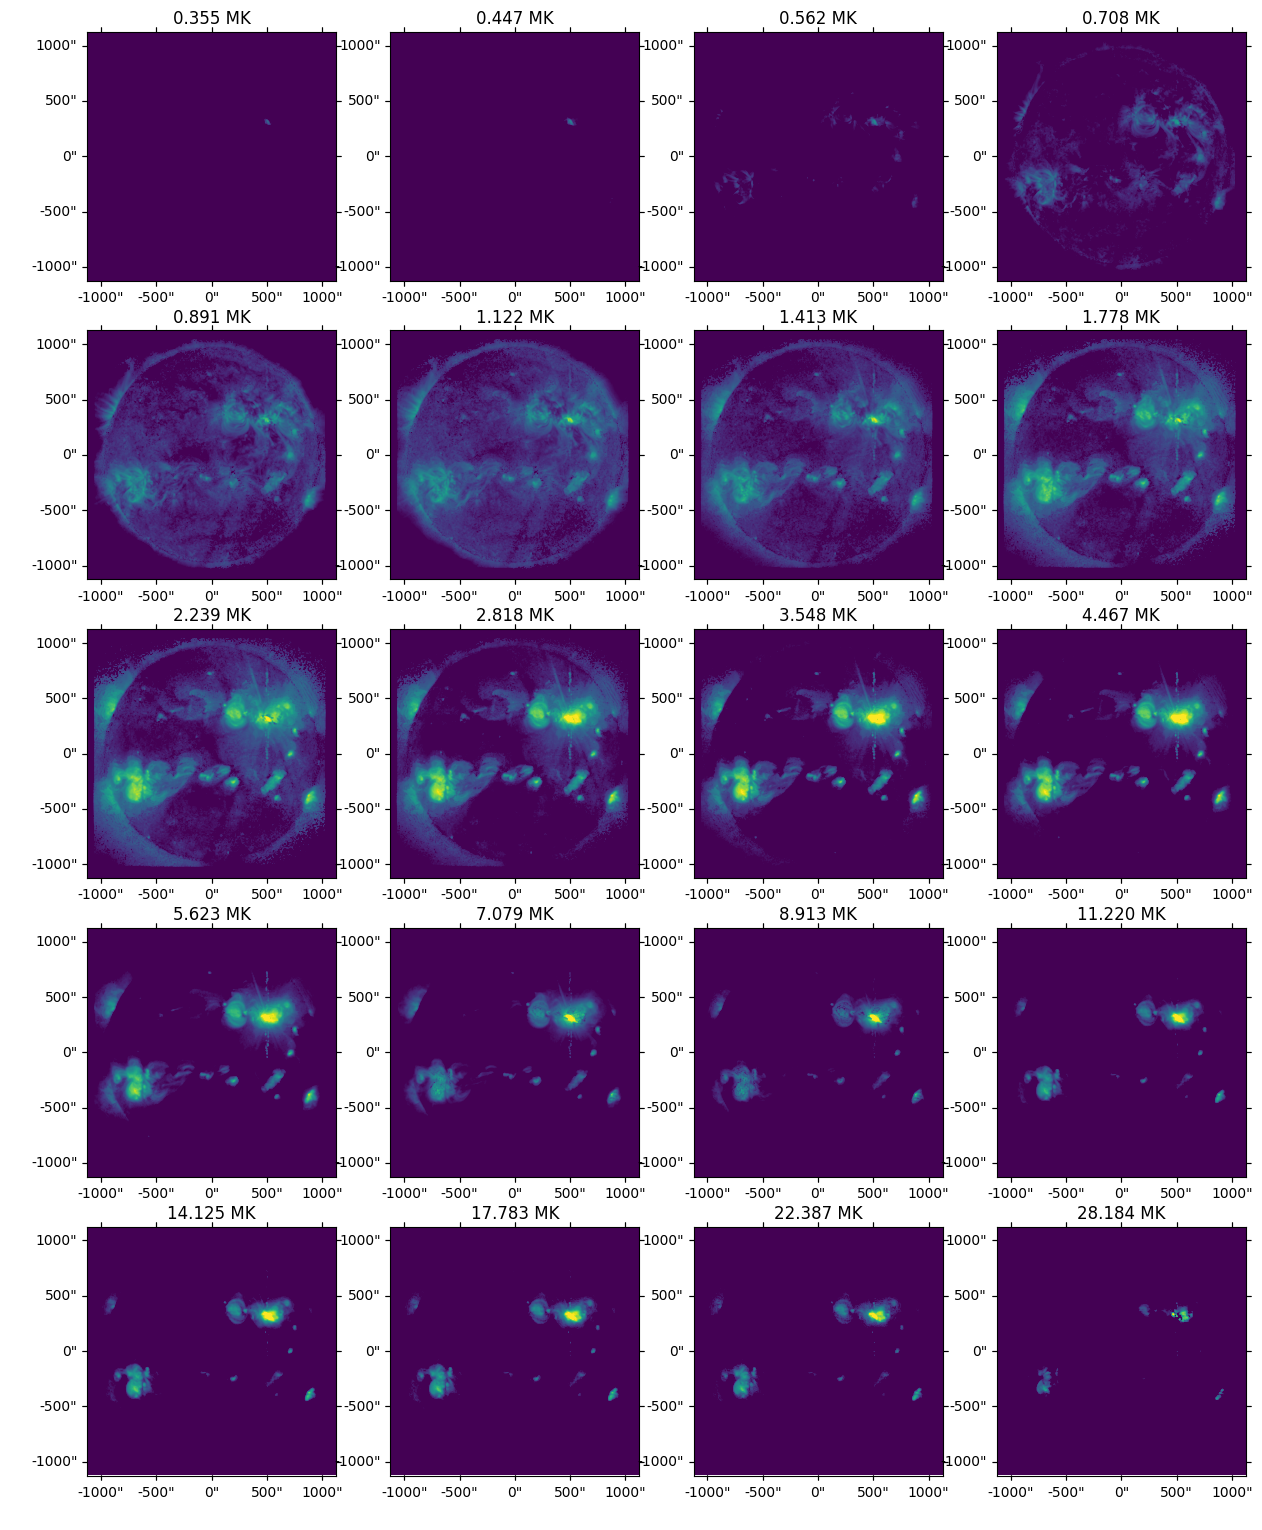

In [103]:
fig = plt.figure(figsize=(15,15*5/4))
for i,cube in enumerate(dem_cube['em']):
    ax = fig.add_subplot(5,4,i+1,projection=cube)
    ax.set_title(f'{dp.temperature_bin_centers[i].to("MK"):.3f}')
    cube.plot(axes=ax,norm=ImageNormalize(vmax=1e28,vmin=1e25,stretch=LogStretch()))
    lon,lat = ax.coords
    lon.set_axislabel(' ')
    lat.set_axislabel(' ')

In [9]:
celestial_wcs = dp.collection['94.0 Angstrom'].wcs

In [113]:
flare_loc = SkyCoord(Tx=510*u.arcsec, Ty=325*u.arcsec, frame=wcs_to_celestial_frame(celestial_wcs))

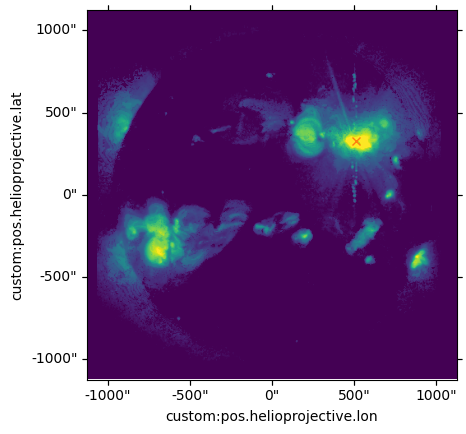

In [114]:
fig = plt.figure()
ax = fig.add_subplot(projection=dem_cube['em'][10].wcs)
dem_cube['em'][10].plot(norm=ImageNormalize(vmax=1e28,vmin=1e25,stretch=LogStretch()),axes=ax)
ax.plot_coord(flare_loc,marker='x',color='C1',ls='')

(1e+25, 5e+28)

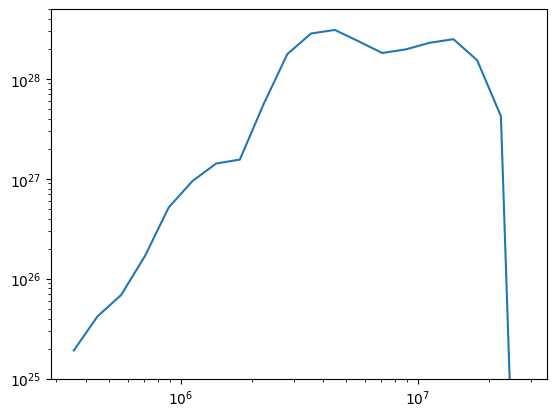

In [116]:
ir,ic = dem_cube['em'][0].wcs.world_to_array_index(flare_loc)
plt.plot(dp.temperature_bin_centers,dem_cube['em'].data[:,ir,ic])
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e25,5e28)

Now use the DEM along with an assumed spectra to create the spectral cube

In [15]:
spec_model = SpectralModel()

In [16]:
spec_cube = spec_model.run(dem_cube['em'], celestial_wcs)

Now, do a few quick tests to see whether our images saturate. We want to test both our 0th order dispersed image as well as our Be-thick image to understand whether we need such a filter for flares.

In [127]:
def make_filtergram_quick(spectral_cube, channel):
    """
    This is a quick and dirty way to compute the filtergram images.
    """
    instr_cube = convolve_with_response(spectral_cube, channel, include_gain=True)
    data = instr_cube.data.sum(axis=0)
    meta = {'FILTER': channel.filter_label}
    summed_cube = ndcube.NDCube(data, wcs=instr_cube[0].wcs, unit=instr_cube.unit, meta=meta)
    # TODO: optionally do an easy reprojection here from one 2D image to another
    return summed_cube

In [52]:
al_thin = ThinFilmFilter(elements='Al', thickness=100*u.nm)
## Case 2
al_thin_oxide = [
    ThinFilmFilter(elements='Al', thickness=93*u.nm),
    ThinFilmFilter(elements=['Al','O'], quantities=[2,3], thickness=7*u.nm),
]
## Case 3
al_thick_oxide = [
    ThinFilmFilter(elements='Al', thickness=192*u.nm),
    ThinFilmFilter(elements=['Al','O'], quantities=[2,3], thickness=8*u.nm),
]
## Case 4
polymide = ThinFilmFilter(elements=['C','H','N','O'],
                          quantities=[22,10,2,5],
                          density=1.43*u.g/u.cm**3,
                          thickness=100*u.nm)
al_poly_thin_oxide = al_thin_oxide + [polymide]
## Case 5
al_poly_thick_oxide = al_thick_oxide + [polymide]

In [53]:
disp_0 = [
    SpectrogramChannel(0, al_thin),
    SpectrogramChannel(0, al_thin_oxide),
    SpectrogramChannel(0, al_thick_oxide),
    SpectrogramChannel(0, al_poly_thin_oxide),
    SpectrogramChannel(0, al_poly_thick_oxide),
]

In [54]:
filtergram_Be_thick = Channel('filtergram1', ThinFilmFilter(elements='Be', thickness=300*u.micron))

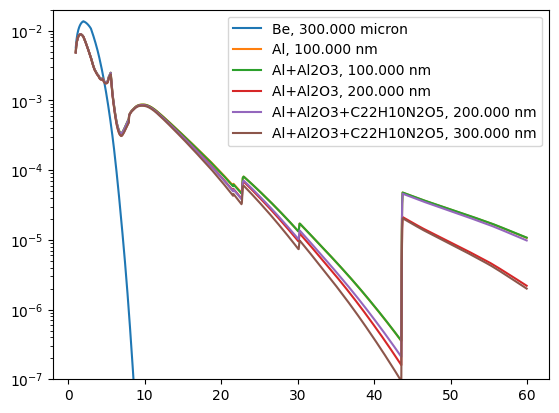

In [95]:
plt.plot(filtergram_Be_thick.wavelength, filtergram_Be_thick.wavelength_response,
         label=filtergram_Be_thick.filter_label)
for chan in disp_0:
    plt.plot(chan.wavelength, chan.wavelength_response,label=chan.filter_label)
plt.yscale('log')
plt.ylim(1e-7,2e-2)
plt.legend()

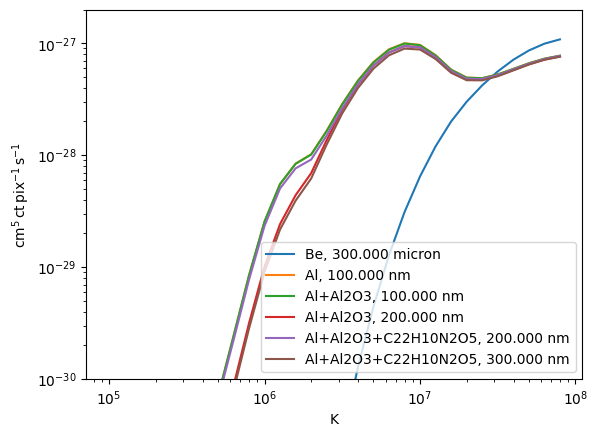

In [99]:
T_be, tresp_be = compute_temperature_response(spec_model.spectral_table,
                                        filtergram_Be_thick.wavelength,
                                        filtergram_Be_thick.wavelength_response*filtergram_Be_thick.plate_scale,
                                        return_temperature=True)
with quantity_support():
    plt.plot(T_be,tresp_be,label=filtergram_Be_thick.filter_label)
    for chan in disp_0:
        T_al, tresp_al = compute_temperature_response(spec_model.spectral_table,
                                              chan.wavelength,
                                              chan.wavelength_response*chan.plate_scale,
                                              return_temperature=True)
        plt.plot(T_al,tresp_al,label=chan.filter_label,)
plt.ylim(1e-30,2e-27)
plt.xscale('log')
plt.yscale('log')
plt.legend()

In [128]:
be_image = make_filtergram_quick(spec_cube[:1500], filtergram_Be_thick)

Text(0.5, 1.0, 'Be, 300.000 micron')

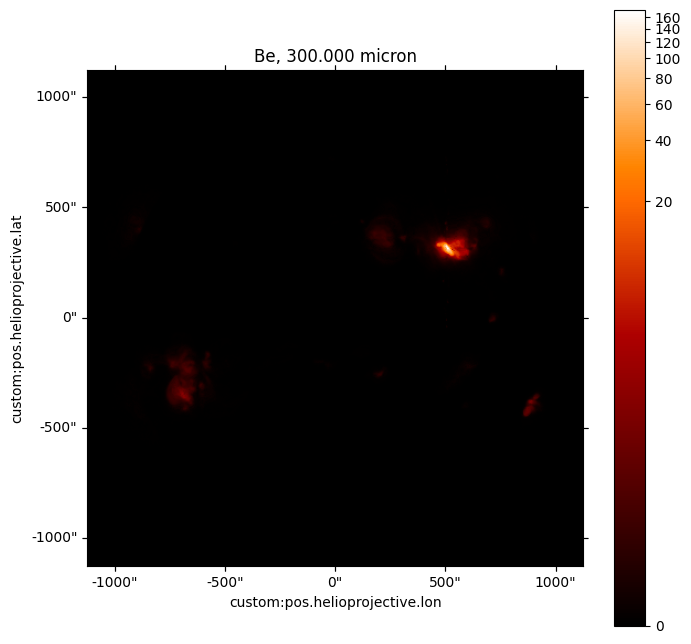

In [131]:
norm = ImageNormalize(stretch=LogStretch())
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection=be_image.wcs)
be_image.plot(cmap='hinodexrt', norm=norm, data_unit='ct / pix / s')
plt.colorbar()
plt.title(filtergram_Be_thick.filter_label)

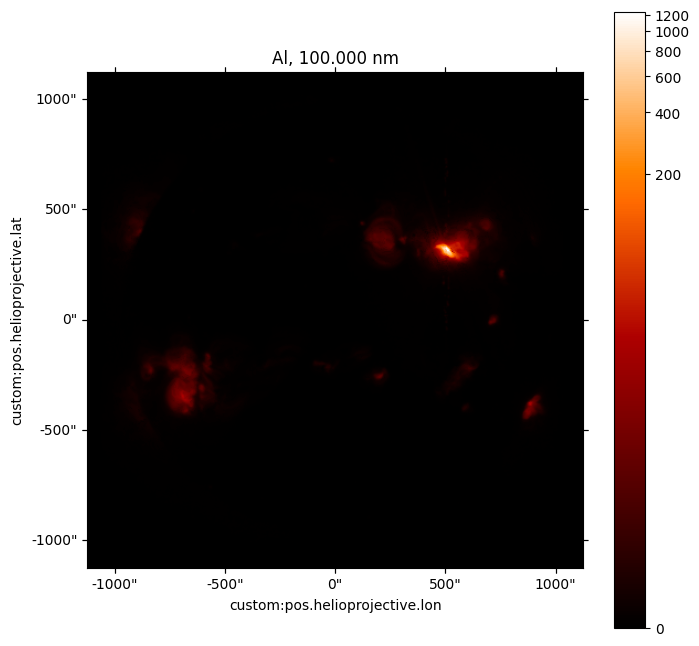

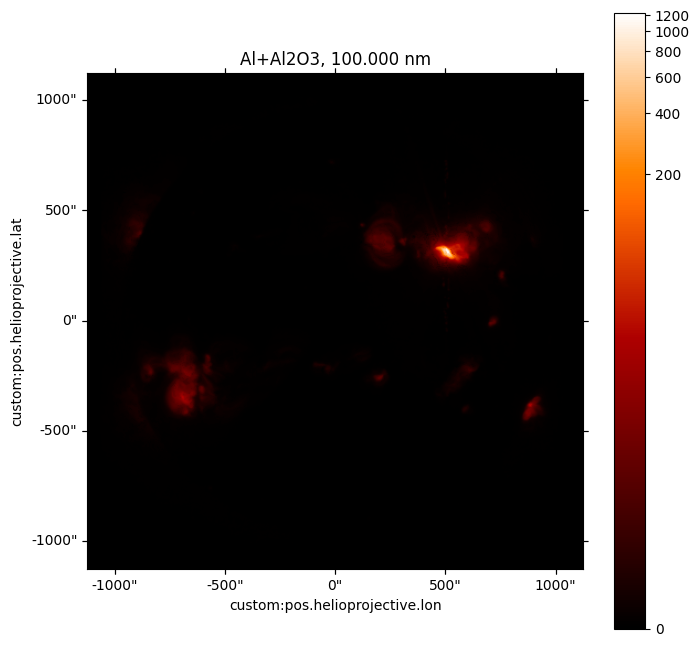

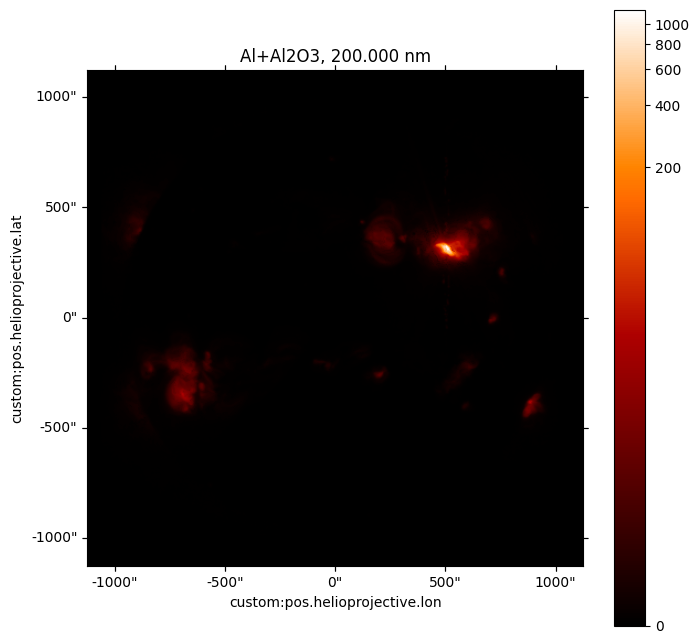

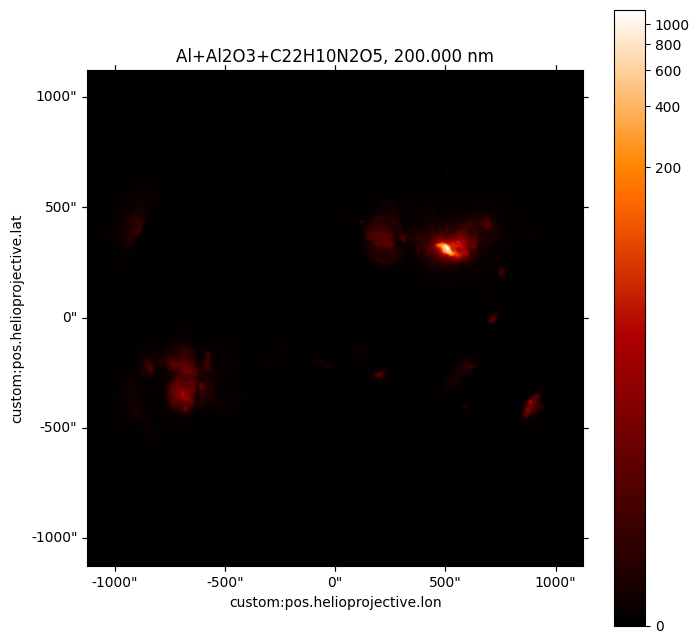

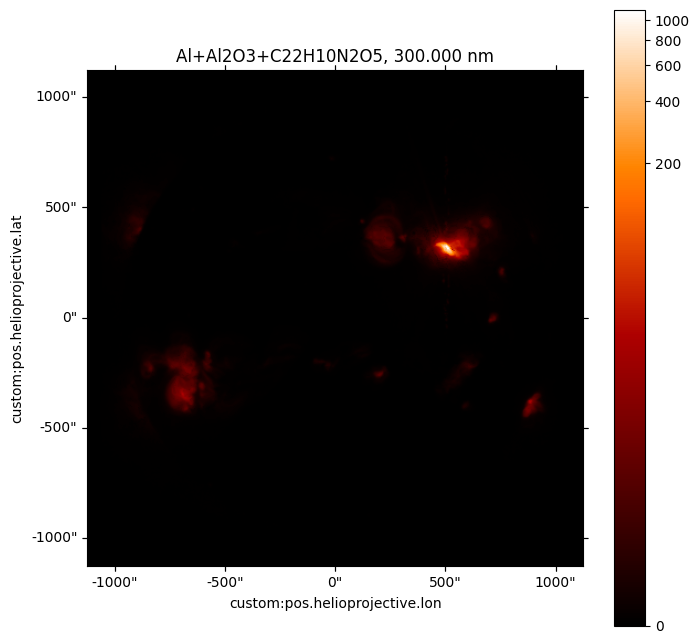

In [132]:
for chan in disp_0:
    disp0_image = make_filtergram_quick(spec_cube[:1500], chan)
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection=disp0_image.wcs)
    disp0_image.plot(axes=ax,cmap='hinodexrt', norm=ImageNormalize(stretch=LogStretch()), data_unit='ct / pix / s')
    plt.colorbar()
    plt.title(chan.filter_label)